In [1]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import resnet50, ResNet50_Weights

from torchvision.ops import FeaturePyramidNetwork

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

from tqdm import tqdm

import numpy as np

import os

import matplotlib.pyplot as plt

from utils.dataset import Dataset

from scipy.stats import pearsonr as corr

from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression


In [2]:
batch_size = 64

In [3]:
data = Dataset('../../data/subj08')
#test_data = Dataset('../../data/subj08', test=True)

train_set, val_set = torch.utils.data.random_split(data, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

Loading dataset sample names...
Training images: 8779
Test images: 395

LH training fMRI data shape:
(8779, 18981)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20530)
(Training stimulus images × RH vertices)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
alexnet.to(device) # send the alexnet to the chosen device ('cpu' or 'cuda')
alexnet.eval() # set the alexnet to evaluation mode, since you are not training it

model_layer = "features.2" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(alexnet, return_nodes=[model_layer])
feature_extractor.to(device)
feature_extractor.eval()

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [5]:
def fit_pca(feature_extractor, dataloader):
    # Define PCA parameters
    pca = IncrementalPCA(n_components=600, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        if _ == len(dataloader)-1:
            break
        # Extract features
        ft = feature_extractor(d[0].to(device))
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())

    return pca

In [6]:
pca = fit_pca(feature_extractor, train_loader)

 93%|█████████▎| 14/15 [04:38<00:19, 19.91s/it]


In [7]:
def extract_features(feature_extractor, dataloader, pca, right=False, test=False):
    fmri = []
    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        if test == False:
            ft = feature_extractor(d[0].to(device))
            if right == False:
                fmri += [d[1].cpu().detach().numpy()]
            else:
                fmri += [d[2].cpu().detach().numpy()]
        else:
            ft = feature_extractor(d.to(device))
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features += [ft]
    if test == False:
        return (np.vstack(features), np.vstack(fmri))
    return np.vstack(features)

In [8]:
right = False

features_train, labels_train = extract_features(feature_extractor, train_loader, pca, right=right)
features_val, labels_val = extract_features(feature_extractor, val_loader, pca, right=right)

100%|██████████| 3/3 [00:17<00:00,  5.90s/it]


In [5]:
class RegressionHead(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(RegressionHead, self).__init__()
        # instead of PCA lin layer for dim reduction
        # 2 conv layers then GAP
        self.conv1 = torch.nn.Conv2d(64, 512, 3)
        self.conv2 = torch.nn.Conv2d(512, 1028, 3)
        self.conv3 = torch.nn.Conv2d(1028, 1028, 3)
        self.conv4 = torch.nn.Conv2d(1028, 1028, 3)
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

        # linear layers for regression outputs
        self.linear1 = torch.nn.Linear(1028, outputSize)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avg_pool(x).squeeze(3).squeeze(2)
        return self.linear1(x)

In [6]:
regression_head = RegressionHead(46656, 18981).to(device)
regression_head.to(device)

RegressionHead(
  (conv1): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(512, 1028, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(1028, 1028, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(1028, 1028, kernel_size=(3, 3), stride=(1, 1))
  (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (linear1): Linear(in_features=1028, out_features=18981, bias=True)
)

In [7]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(regression_head.parameters(), lr=0.0001)

In [8]:
losses = []
val_losses = []

for epoch in range(50):
    print(f"Epoch {epoch}")
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)-1):
        optimizer.zero_grad()

        input_data = data[0]
        left_label = data[1]

        output = feature_extractor(input_data.to(device))
        output = regression_head(output["features.2"])

        loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
        
        if i == len(train_loader)-1:
            losses.append(loss.item())
            print("Train loss: " + str(loss.item()))

        loss.backward()
        
        optimizer.step()
    
    for i, data in tqdm(enumerate(val_loader), total=len(val_loader)-1):
        input_data = data[0]
        left_label = data[1]

        output = feature_extractor(input_data.to(device))
        output = regression_head(output["features.2"])

        loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
        
        if i == len(val_loader)-1:
            val_losses.append(loss.item())
            print("Val loss: " + str(loss.item()))

Epoch 0


  0%|          | 0/137 [00:00<?, ?it/s]/tmp/ipykernel_14017/2013069477.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
138it [01:36,  1.43it/s]                         


Train loss: 0.5329475998878479


  0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_14017/2013069477.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(left_label, dtype=torch.float32).to(device))
28it [00:18,  1.47it/s]                        


Val loss: 0.5856663584709167
Epoch 1


138it [01:35,  1.44it/s]                         


Train loss: 0.6593087315559387


28it [00:18,  1.48it/s]                        


Val loss: 0.5227978825569153
Epoch 2


138it [01:35,  1.44it/s]                         


Train loss: 0.5047295689582825


28it [00:19,  1.45it/s]                        


Val loss: 0.5202301740646362
Epoch 3


138it [01:34,  1.45it/s]                         


Train loss: 0.507054328918457


28it [00:18,  1.49it/s]                        


Val loss: 0.6212515830993652
Epoch 4


138it [01:34,  1.46it/s]                         


Train loss: 0.5191553235054016


28it [00:18,  1.51it/s]                        


Val loss: 0.5075547099113464
Epoch 5


138it [01:33,  1.48it/s]                         


Train loss: 0.41934677958488464


28it [00:18,  1.50it/s]                        


Val loss: 0.612432599067688
Epoch 6


138it [01:34,  1.47it/s]                         


Train loss: 0.5205565690994263


28it [00:18,  1.51it/s]                        


Val loss: 0.5560842156410217
Epoch 7


138it [01:33,  1.47it/s]                         


Train loss: 0.7279568314552307


28it [00:18,  1.50it/s]                        


Val loss: 0.4819641709327698
Epoch 8


138it [01:33,  1.47it/s]                         


Train loss: 0.562762439250946


28it [00:18,  1.48it/s]                        


Val loss: 0.612174928188324
Epoch 9


138it [01:36,  1.43it/s]                         


Train loss: 0.5914503931999207


28it [00:19,  1.45it/s]                        


Val loss: 0.5593684315681458
Epoch 10


138it [01:35,  1.44it/s]                         


Train loss: 0.8414790630340576


28it [00:19,  1.47it/s]                        


Val loss: 0.5183261632919312
Epoch 11


138it [01:35,  1.45it/s]                         


Train loss: 0.6716383099555969


28it [00:18,  1.49it/s]                        


Val loss: 0.5174187421798706
Epoch 12


138it [01:35,  1.44it/s]                         


Train loss: 0.7383222579956055


28it [00:19,  1.47it/s]                        


Val loss: 0.5419390797615051
Epoch 13


138it [01:36,  1.44it/s]                         


Train loss: 0.5961849689483643


28it [00:19,  1.47it/s]                        


Val loss: 0.4991702437400818
Epoch 14


138it [01:37,  1.42it/s]                         


Train loss: 0.4959929585456848


28it [00:19,  1.45it/s]                        


Val loss: 0.6439374089241028
Epoch 15


138it [01:38,  1.41it/s]                         


Train loss: 0.5593360662460327


28it [00:19,  1.42it/s]                        


Val loss: 0.4804806411266327
Epoch 16


138it [01:38,  1.41it/s]                         


Train loss: 0.5234424471855164


28it [00:19,  1.44it/s]                        


Val loss: 0.6221638321876526
Epoch 17


138it [01:37,  1.42it/s]                         


Train loss: 0.6167063117027283


28it [00:19,  1.44it/s]                        


Val loss: 0.5392553210258484
Epoch 18


138it [01:36,  1.43it/s]                         


Train loss: 0.6531283855438232


28it [00:19,  1.44it/s]                        


Val loss: 0.5803140997886658
Epoch 19


138it [01:37,  1.42it/s]                         


Train loss: 0.5387852787971497


28it [00:19,  1.46it/s]                        


Val loss: 0.4797237515449524
Epoch 20


138it [01:36,  1.42it/s]                         


Train loss: 0.577460527420044


28it [00:19,  1.45it/s]                        


Val loss: 0.5806095600128174
Epoch 21


138it [01:36,  1.42it/s]                         


Train loss: 0.5184070467948914


28it [00:19,  1.46it/s]                        


Val loss: 0.5401543378829956
Epoch 22


138it [01:35,  1.45it/s]                         


Train loss: 0.7132496237754822


28it [00:19,  1.47it/s]                        


Val loss: 0.5919086933135986
Epoch 23


138it [01:35,  1.44it/s]                         


Train loss: 0.6742053627967834


28it [00:19,  1.46it/s]                        


Val loss: 0.4997704327106476
Epoch 24


138it [01:36,  1.43it/s]                         


Train loss: 0.7605385184288025


28it [00:18,  1.47it/s]                        


Val loss: 0.5534335374832153
Epoch 25


138it [01:35,  1.44it/s]                         


Train loss: 0.679997444152832


28it [00:19,  1.46it/s]                        


Val loss: 0.6746050119400024
Epoch 26


138it [01:35,  1.45it/s]                         


Train loss: 0.4241170585155487


28it [00:19,  1.47it/s]                        


Val loss: 0.5530077219009399
Epoch 27


138it [01:35,  1.44it/s]                         


Train loss: 0.5049065947532654


28it [00:19,  1.45it/s]                        


Val loss: 0.5117629170417786
Epoch 28


138it [01:36,  1.43it/s]                         


Train loss: 0.4908619225025177


28it [00:19,  1.46it/s]                        


Val loss: 0.4817655682563782
Epoch 29


138it [01:37,  1.41it/s]                         


Train loss: 0.751991868019104


28it [00:19,  1.46it/s]                        


Val loss: 0.515726625919342
Epoch 30


138it [01:36,  1.43it/s]                         


Train loss: 0.442791223526001


28it [00:19,  1.46it/s]                        


Val loss: 0.5429326891899109
Epoch 31


138it [01:37,  1.42it/s]                         


Train loss: 0.48739567399024963


28it [00:19,  1.46it/s]                        


Val loss: 0.5421851873397827
Epoch 32


138it [01:36,  1.42it/s]                         


Train loss: 0.6460294127464294


28it [00:19,  1.45it/s]                        


Val loss: 0.6048367023468018
Epoch 33


138it [01:37,  1.41it/s]                         


Train loss: 0.5585862398147583


28it [00:19,  1.45it/s]                        


Val loss: 0.6393610835075378
Epoch 34


138it [01:36,  1.43it/s]                         


Train loss: 0.4647519588470459


28it [00:19,  1.45it/s]                        


Val loss: 0.5506372451782227
Epoch 35


138it [01:36,  1.43it/s]                         


Train loss: 0.688122570514679


28it [00:18,  1.48it/s]                        


Val loss: 0.5551878809928894
Epoch 36


138it [01:35,  1.44it/s]                         


Train loss: 0.537509560585022


28it [00:19,  1.47it/s]                        


Val loss: 0.5564765930175781
Epoch 37


138it [01:36,  1.43it/s]                         


Train loss: 0.5763224959373474


28it [00:19,  1.45it/s]                        


Val loss: 0.5087838768959045
Epoch 38


138it [01:36,  1.43it/s]                         


Train loss: 0.42323052883148193


28it [00:19,  1.47it/s]                        


Val loss: 0.5169650912284851
Epoch 39


138it [01:36,  1.44it/s]                         


Train loss: 0.5234583020210266


28it [00:19,  1.44it/s]                        


Val loss: 0.6960602402687073
Epoch 40


138it [01:36,  1.42it/s]                         


Train loss: 0.5806163549423218


28it [00:19,  1.47it/s]                        


Val loss: 0.4687536656856537
Epoch 41


138it [01:35,  1.44it/s]                         


Train loss: 0.6047385931015015


28it [00:19,  1.46it/s]                        


Val loss: 0.6073328256607056
Epoch 42


138it [01:36,  1.42it/s]                         


Train loss: 0.6367200016975403


28it [00:19,  1.45it/s]                        


Val loss: 0.5216205716133118
Epoch 43


138it [01:36,  1.43it/s]                         


Train loss: 0.6889469027519226


28it [00:19,  1.45it/s]                        


Val loss: 0.5992703437805176
Epoch 44


138it [01:36,  1.43it/s]                         


Train loss: 0.481751948595047


28it [00:19,  1.45it/s]                        


Val loss: 0.6151639819145203
Epoch 45


138it [01:37,  1.42it/s]                         


Train loss: 0.6673557758331299


28it [00:19,  1.46it/s]                        


Val loss: 0.5896016359329224
Epoch 46


138it [01:36,  1.43it/s]                         


Train loss: 0.3896220326423645


28it [00:19,  1.47it/s]                        


Val loss: 0.6175430417060852
Epoch 47


138it [01:36,  1.43it/s]                         


Train loss: 0.5758680105209351


28it [00:19,  1.46it/s]                        


Val loss: 0.5301885008811951
Epoch 48


138it [01:36,  1.43it/s]                         


Train loss: 0.5053097605705261


28it [00:19,  1.45it/s]                        


Val loss: 0.6082223057746887
Epoch 49


138it [01:35,  1.44it/s]                         


Train loss: 0.6738121509552002


28it [00:19,  1.44it/s]                        

Val loss: 0.5285000205039978


Text(0.5, 1.0, 'Loss over time, lr=0.01, epochs=10, batch_size=100')

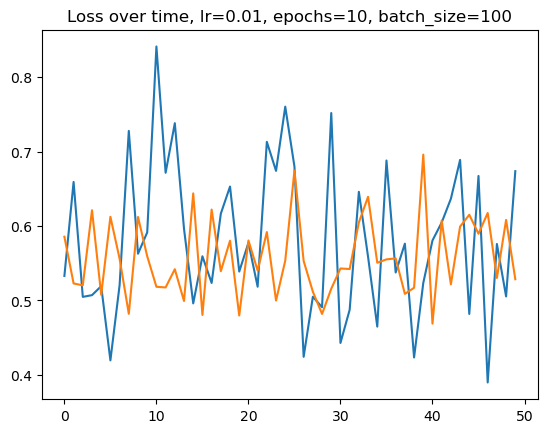

In [9]:
plt.plot(losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.title("Loss over time, lr=0.01, epochs=10, batch_size=100")

In [41]:
features_val = torch.tensor(features_val, dtype=torch.float32)
fmri_val_pred = regression_head(torch.tensor(features_val, dtype=torch.float32).to(device)).detach().cpu()

NameError: name 'features_val' is not defined

In [32]:
from scipy.stats import pearsonr as corr

# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(fmri_val_pred[:,v], labels_val[:,v])[0]

score = np.median(lh_correlation) * 100
print(score)

100%|██████████| 18981/18981 [00:04<00:00, 4263.19it/s]

27.168944638566927


In [64]:
from scipy.stats import pearsonr as corr

# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(fmri_train_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(fmri_train_pred.shape[1])):
    lh_correlation[v] = corr(fmri_train_pred[:,v], labels_train[:,v])[0]

score = np.median(lh_correlation) * 100
print(score)

100%|██████████| 18981/18981 [00:23<00:00, 817.71it/s]

17.16843448730859
